In [1]:
from anndata import AnnData
import scanpy as sc
import squidpy as sq
import pandas as pd
import anndata

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

Set parameters

In [2]:
neighbors = 15
nPCs = 30
leiden_resolution = 1

In [3]:
adata_CosMx = sc.read_h5ad("/home/levinsj/spatial/adata/project_Files/Fetal/fetal_annotated_AllCells.h5ad")
adata_scRNA = sc.read_h5ad("/home/levinsj/Fetal_dir/CellBenderCorrected/04_annotated/MergedFetalOnly_annotated_all_final.h5ad")

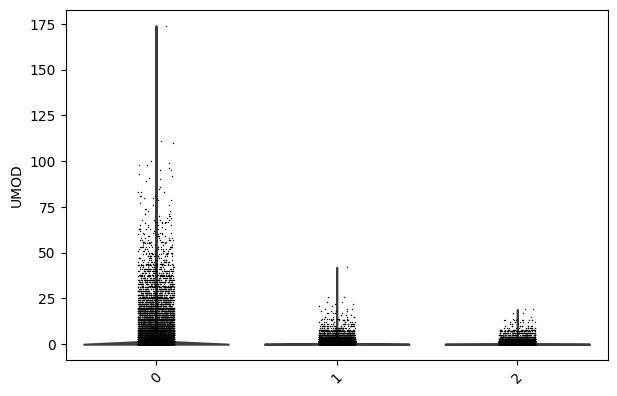

In [4]:
adata_CosMx.obs['Count_percentile'] = adata_CosMx.obs['nCount_RNA'].rank(pct=True) * 100
adata_CosMx.layers["counts"] = adata_CosMx.layers["All_counts"].copy()
adata_CosMx.obs["tech"] = "CosMx"

sc.pl.violin(adata_CosMx, keys = ['UMOD'],  size = 1, groupby = 'sample', rotation= 45, layer = "counts")


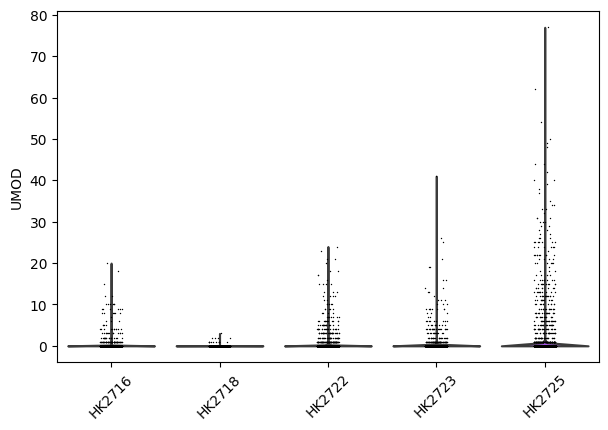

In [5]:
adata_scRNA.obs['Count_percentile'] = adata_scRNA.obs['total_counts'].rank(pct=True) * 100
adata_scRNA.obs["tech"] = "scRNA"

sc.pl.violin(adata_scRNA, keys = ['UMOD'],  size = 1, groupby = 'sample', rotation= 45,use_raw = False, layer = "counts")


In [6]:
adata_merge = anndata.concat([adata_CosMx,adata_scRNA], join = "outer")

adata_merge

AnnData object with n_obs × n_vars = 541047 × 24485
    obs: 'cell', 'nCount_RNA', 'nFeature_RNA', 'nCount_negprobes', 'nFeature_negprobes', 'nCount_falsecode', 'nFeature_falsecode', 'fov', 'Area', 'AspectRatio', 'Width', 'Height', 'Mean.B', 'Max.B', 'Mean.CK8.18', 'Max.CK8.18', 'Mean.Membrane', 'Max.Membrane', 'Mean.R', 'Max.R', 'Mean.DAPI', 'Max.DAPI', 'cell_id', 'assay_type', 'slide_ID', 'Run_Tissue_name', 'Panel', 'CenterX_global_px', 'CenterY_global_px', 'cell_ID', 'sample', 'type', 'meanCounts_perFOV', 'Mean.PanCK', 'Max.PanCK', 'Mean.CD45', 'Max.CD45', 'pct_nuc', 'pct_mem', 'pct_cyt', 'n_counts', 'leiden', 'cellType_CosMx_1', 'Count_percentile', 'tech', 'doublet_scores', 'predicted_doublets', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'S_score', 'G2M_score', 'phase', 'cellType', 'leiden2', 'cellType2', 'cellType3'
    obsm: 'X_pca', 'X_umap', 'spatial', 'spatial_fov', 'X_pca_harmony'
    layers: 'All_counts', 'Cytoplasm', 'Membrane', 'Nuc

In [7]:
adata_merge.layers

Layers with keys: All_counts, Cytoplasm, Membrane, Nuclear, counts, log1p

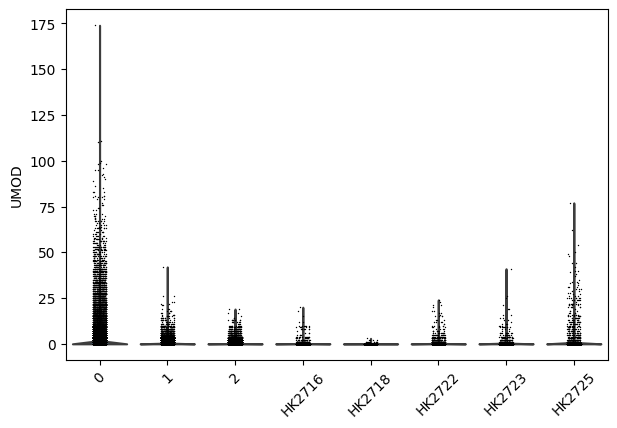

In [8]:
sc.pl.violin(adata_merge, keys = ['UMOD'],  size = 1, groupby = 'sample', rotation= 45, layer = "counts")


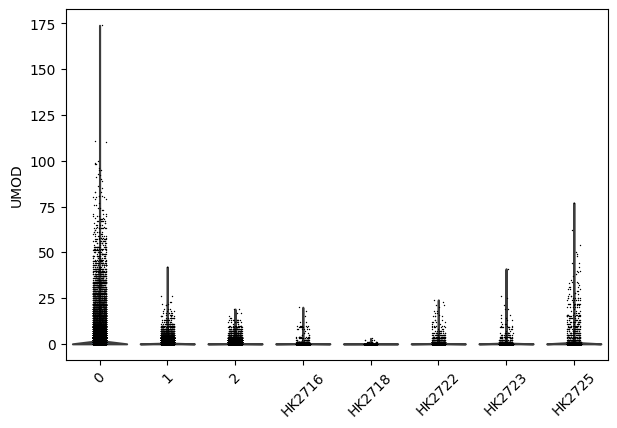

In [9]:
adata_merge.X = adata_merge.layers["counts"]

keep_str = ["sample","phase","type", 'cellType','cellType3','tech',"cellType_CosMx_1",'leiden','fov',"cell_ID"]
keep_numer = ["pct_counts_mt","pct_nuc","total_counts","nCount_RNA", "n_genes_by_counts",'CenterX_global_px', 'CenterY_global_px', 'Area','Count_percentile','Mean.DAPI', 'Max.DAPI', 'G2M_score', "S_score"]
keep = keep_str + keep_numer
adata_merge.obs= adata_merge.obs[keep]

# ensure proper data types
for i in keep_str:
    adata_merge.obs[i]= adata_merge.obs[i].astype('str')

for i in keep_numer:
    adata_merge.obs[i]= adata_merge.obs[i].astype('float')
    
ageKey = {'0': '19', '1': '18', '2': '15', 'HK2725': '19', 'HK2716': '15', 'HK2722': '14', 'HK2718': '12', 'HK2723': '20'}
adata_merge.obs["gAge"] = adata_merge.obs['sample'].map(ageKey).astype('category')

sc.pl.violin(adata_merge, keys = ['UMOD'],  size = 1, groupby = 'sample', rotation= 45, layer = "counts")


In [10]:
adata_merge.raw = adata_merge

adata_merge = adata_merge[:,adata_CosMx.var_names]

systemChecks = adata_merge.var_names.str.startswith('SystemControl')
neg_probes = adata_merge.var_names.str.startswith('Negative')
remove = np.add(neg_probes, systemChecks)
keep = np.invert(remove)

adata_merge = adata_merge[:,keep]

In [11]:
malat1 = adata_merge.var_names.str.startswith('MALAT1')
mito_genes = adata_merge.var_names.str.startswith('MT-')
hb_genes = adata_merge.var_names.str.contains('^HB[^(P)]')

remove = np.add(mito_genes, malat1)
remove = np.add(remove, hb_genes)

keep = np.invert(remove)

adata_merge = adata_merge[:,keep]

In [12]:
print(adata_merge)

adata_merge.write_h5ad(filename = "/home/levinsj/spatial/adata/project_Files/Fetal/fetal_annotated_AllCells_preSCVI_final.h5ad")


View of AnnData object with n_obs × n_vars = 541047 × 995
    obs: 'sample', 'phase', 'type', 'cellType', 'cellType3', 'tech', 'cellType_CosMx_1', 'leiden', 'fov', 'cell_ID', 'pct_counts_mt', 'pct_nuc', 'total_counts', 'nCount_RNA', 'n_genes_by_counts', 'CenterX_global_px', 'CenterY_global_px', 'Area', 'Count_percentile', 'Mean.DAPI', 'Max.DAPI', 'G2M_score', 'S_score', 'gAge'
    uns: 'sample_colors'
    obsm: 'X_pca', 'X_umap', 'spatial', 'spatial_fov', 'X_pca_harmony'
    layers: 'All_counts', 'Cytoplasm', 'Membrane', 'Nuclear', 'counts', 'log1p'


In [13]:
keep_str = ["sample",'tech','fov',"cell_ID", "gAge"]
keep_numer = ['CenterX_global_px', 'CenterY_global_px', 'Area']
keep = keep_str + keep_numer
adata_merge.obs= adata_merge.obs[keep]

del adata_merge.uns
del adata_merge.obsm


# ensure proper data types
for i in keep_str:
    adata_merge.obs[i]= adata_merge.obs[i].astype('str')

for i in keep_numer:
    adata_merge.obs[i]= adata_merge.obs[i].astype('float')

adata_merge.X = adata_merge.layers["All_counts"]

/usr/local/lib/python3.8/dist-packages/anndata/_core/anndata.py:859: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  self._set_dim_df(value, "obs")


In [14]:
layers_to_remove = ['Cytoplasm', 'Membrane', 'Nuclear', 'counts', 'log1p']
for layer_name in layers_to_remove:
    del adata_merge.layers[layer_name]

In [15]:
adata1 = adata_merge[adata_merge.obs["sample"] == "0"]
adata2 = adata_merge[adata_merge.obs["sample"] == "1"]
adata3 = adata_merge[adata_merge.obs["sample"] == "2"]

samples = [adata1, adata2, adata3]

print(samples)

[View of AnnData object with n_obs × n_vars = 118197 × 995
    obs: 'sample', 'tech', 'fov', 'cell_ID', 'gAge', 'CenterX_global_px', 'CenterY_global_px', 'Area'
    layers: 'All_counts', View of AnnData object with n_obs × n_vars = 230538 × 995
    obs: 'sample', 'tech', 'fov', 'cell_ID', 'gAge', 'CenterX_global_px', 'CenterY_global_px', 'Area'
    layers: 'All_counts', View of AnnData object with n_obs × n_vars = 127023 × 995
    obs: 'sample', 'tech', 'fov', 'cell_ID', 'gAge', 'CenterX_global_px', 'CenterY_global_px', 'Area'
    layers: 'All_counts']


In [16]:
adata1.write_h5ad(filename = "/home/levinsj/spatial/adata/project_Files/Fetal/HK3524_raw.h5ad")
adata2.write_h5ad(filename = "/home/levinsj/spatial/adata/project_Files/Fetal/FK1_raw.h5ad")
adata3.write_h5ad(filename = "/home/levinsj/spatial/adata/project_Files/Fetal/FK4_raw.h5ad")


/usr/local/lib/python3.8/dist-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/usr/lib/python3.8/contextlib.py:120: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  next(self.gen)
/usr/local/lib/python3.8/dist-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/usr/local/lib/python3.8/dist-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/usr/local/lib/python3.8/dist-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view,

In [17]:
print(adata1.X)
print(adata1.obs)
print(adata1.var_names)

  (0, 1)	1.0
  (0, 35)	1.0
  (0, 43)	3.0
  (0, 68)	2.0
  (0, 100)	2.0
  (0, 105)	1.0
  (0, 129)	1.0
  (0, 140)	1.0
  (0, 146)	1.0
  (0, 148)	1.0
  (0, 174)	1.0
  (0, 176)	1.0
  (0, 207)	1.0
  (0, 220)	1.0
  (0, 243)	2.0
  (0, 246)	1.0
  (0, 251)	1.0
  (0, 266)	1.0
  (0, 283)	1.0
  (0, 318)	2.0
  (0, 328)	1.0
  (0, 352)	1.0
  (0, 390)	2.0
  (0, 425)	1.0
  (0, 455)	1.0
  :	:
  (118196, 308)	1.0
  (118196, 314)	1.0
  (118196, 405)	1.0
  (118196, 417)	1.0
  (118196, 438)	4.0
  (118196, 470)	1.0
  (118196, 473)	3.0
  (118196, 479)	1.0
  (118196, 511)	1.0
  (118196, 547)	1.0
  (118196, 606)	1.0
  (118196, 624)	1.0
  (118196, 674)	1.0
  (118196, 687)	1.0
  (118196, 698)	2.0
  (118196, 719)	1.0
  (118196, 727)	1.0
  (118196, 744)	2.0
  (118196, 768)	1.0
  (118196, 779)	1.0
  (118196, 797)	1.0
  (118196, 945)	1.0
  (118196, 967)	1.0
  (118196, 971)	1.0
  (118196, 979)	1.0
           sample   tech  fov cell_ID gAge  CenterX_global_px  \
1_1-0           0  CosMx    1     1.0   19       54686.0000